# The Effect of Influenza Vaccine on the Likelihood of Contracting Influenza
## The George Washington University -- Masters of Science in Data Science Capstone, DATS6501
## A. Jassal
### May 2019

## Environment Preparation


In [37]:
### Basic Packages

import os

import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from sklearn import metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

import datetime as DT
from imblearn.over_sampling import SMOTE
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### Provide the path here:

os.chdir('C:\\Users\\akash\\Desktop\\GWU\\6501_Capstone\\data')

## Data Preparation

In [4]:
### Data Load and Basic Preparation

#### File_1
df1_flu16 = pd.read_excel('FluShots20162017v2.xlsx',sheet_name='2016')
df1_flu16.columns.values[7] = "Pt Ins"
df1_flu16 = df1_flu16.drop(['Diagnosis Codes','Diagnosis Codes_1'], axis =1)
df1_flu16.rename(columns={'Diagnosis Codes_2':'Diagnosis Codes','Account Number':'AcctNum'}, inplace=True)
df1_flu16['year'] = 2016

#### File_2
df1_flu17 = pd.read_excel('FluShots20162017v2.xlsx',sheet_name='2017')
df1_flu17.rename(columns={'Pt Address 1':'Pt Address 2','CPT Description':'Pt Address 1','CPT.1':'CPT Description','Account Number':'AcctNum'}, inplace=True)
df1_flu17['year'] = 2017
df1_flu1617 = pd.concat([df1_flu16,df1_flu17], sort = False)
df1_flu1617 = df1_flu1617[pd.to_numeric(df1_flu1617['AcctNum'], errors='coerce').notnull()]
df1_flu1617['AcctNum'] = pd.to_numeric(df1_flu1617['AcctNum'])

#### File_1+2 Combination
present_date = pd.Timestamp(DT.datetime.now())
relative_date = DT.datetime(2019,12,31)
df1_flu1617['Pt DOB'] = pd.to_datetime(df1_flu1617['Pt DOB'], format='%m%d%y')
df1_flu1617['Pt DOB'] = df1_flu1617['Pt DOB'].where(df1_flu1617['Pt DOB'] < relative_date, df1_flu1617['Pt DOB'] -  np.timedelta64(100, 'Y'))
df1_flu1617['Pt_Age'] = (relative_date - df1_flu1617['Pt DOB']).astype('<m8[Y]')

#### File_3
df1_fluDx = pd.read_excel('DiagnosisReport_20162017.xlsx',sheet_name='PT1005_pat_diagnosis_list.rpt')
df1_fluDx = df1_fluDx.copy(deep = True)
df1_fluDx.rename(columns={'Patient account':'AcctNum'}, inplace=True)
df1_fluDx = df1_fluDx[['AcctNum']]
df1_fluDx = df1_fluDx.dropna(how = 'all')
df1_fluDx['AcctNum'] = df1_fluDx['AcctNum'].str.split('-').str[0]
df1_fluDx = df1_fluDx[pd.to_numeric(df1_fluDx['AcctNum'], errors='coerce').notnull()]
df1_fluDx['AcctNum'] = pd.to_numeric(df1_fluDx['AcctNum'])
df1_fluDx['FluDx_YES'] = df1_fluDx.notnull().all(1).astype(int)
df1_fluDx =df1_fluDx.reset_index(drop = True)

### Merge 1+2 & 3 into DataFrame
df1 = pd.merge(df1_flu1617,df1_fluDx,left_on = 'AcctNum',right_on = 'AcctNum', how = 'left')
df1['FluDx_YES'].replace(np.nan,'0',inplace=True)
df1['FluDx_YES'] = pd.to_numeric(df1['FluDx_YES'])
df1.columns = df1.columns.str.upper()

df1.to_excel("df1.xlsx")
df1 = pd.read_excel('df1.xlsx',sheet_name='Sheet1')

In [25]:
### Drop Columns
df1b = df1.copy(deep = False)
df1b = df1.drop(['ACCTNUM','PCP','LMG PRACTICE','DOS','DIAGNOSIS CODES',
        'PLACE OF SERVICE', 'CPT DESCRIPTION','PT ADDRESS 1',
        'PT ADDRESS 2','PT CITY', 'PT DOB', 'UNITS', 'YEAR'], axis=1) #'PT ZIP'

print('Shape of Data After Dropping Cols:',df1b.shape, '\n')
print('Null Check After Dropping Cols:\n',df1b.isnull().sum(),'\n')                                          

### Drop Rows
df1b.dropna(inplace=True)
print('Null Check After Dropping Cols & Rows:\n',df1b.isnull().sum(),'\n')                                          

### Value Counts
for f in df1b.columns:
    print('ValueCounts of All Fields: \n',df1b[f].value_counts())

Shape of Data After Dropping Cols: (54205, 9) 

Null Check After Dropping Cols:
 PCP SPECIALTY    1560
PT INS              0
CPT                 0
PT STATE           11
PT ZIP             14
PT GENDER           0
PT RACE             0
PT_AGE              0
FLUDX_YES           0
dtype: int64 

Null Check After Dropping Cols & Rows:
 PCP SPECIALTY    0
PT INS           0
CPT              0
PT STATE         0
PT ZIP           0
PT GENDER        0
PT RACE          0
PT_AGE           0
FLUDX_YES        0
dtype: int64 

ValueCounts of All Fields: 
 Pediatrics               22626
Family Practice          21110
Internal Medicine         8702
Infectious Disease         116
Obstetrics/Gynecology       58
Allergy & Immunology        19
Name: PCP SPECIALTY, dtype: int64
ValueCounts of All Fields: 
 BCBS       17920
UNITED      8625
CIGNA       8563
AETNA       8262
MCARE       5219
TRICARE     1631
MCAID       1419
COMM         415
NONE         326
PHCS          81
MULPN         50
FIRST         2

In [26]:
### Define Lower Limit Thresholds (Percent)
lt_pt_state = 90
lt_pcp_speciality = 35
lt_pt_ins = 14
lt_pt_race = 30
lt_cpt = 15
lt_zip = 2.8

### Combining Variables' Category into Other_Category

df1b['AGE_BIN']= pd.cut(df1b['PT_AGE'],[0,7,17,54,106], right = True, labels = ['Baby','Child','Adult','Senior'] )
# (0,7]|(7,17]|(17,54]|(54,106]

series = pd.value_counts(df1b['PT STATE'])
mask = (series/series.sum() * 100)                  # To replace df['column'] use np.where I.e
mask = (series/series.sum() * 100).lt(lt_pt_state)          # lt(%); where % is the cut off
df1b['PT STATE'] = np.where(df1b['PT STATE'].isin(series[mask].index),'Other',df1b['PT STATE'])

series = pd.value_counts(df1b['PCP SPECIALTY'])
mask = (series/series.sum() * 100)
mask = (series/series.sum() * 100).lt(lt_pcp_speciality)
df1b['PCP SPECIALTY'] = np.where(df1b['PCP SPECIALTY'].isin(series[mask].index),'Other',df1b['PCP SPECIALTY'])

series = pd.value_counts(df1b['PT INS'])
mask = (series/series.sum() * 100)
mask = (series/series.sum() * 100).lt(lt_pt_ins)
df1b['PT INS'] = np.where(df1b['PT INS'].isin(series[mask].index),'Other',df1b['PT INS'])

series = pd.value_counts(df1b['PT ZIP'])
mask = (series/series.sum() * 100)
mask = (series/series.sum() * 100).lt(lt_zip)
df1b['PT ZIP'] = np.where(df1b['PT ZIP'].isin(series[mask].index),'Other',df1b['PT ZIP'])

new = series[~mask]
new['Other'] = series[mask].sum()
series.index = np.where(series.index.isin(series[mask].index),'Other',series.index)

### Export Results to Excel
df1b.to_excel("df1b_2.xlsx")

In [27]:
df2 = df1b.copy(deep = True)

### Drop Columns that are not used
df2 = df2.drop(['PT RACE','PT_AGE', 'CPT'],axis =1)
df2_feats = list(df2)

### Dummify the Remaining Cols
df2 = pd.get_dummies(df2,columns = ['PT GENDER','PT STATE','PCP SPECIALTY','PT INS','PT ZIP','AGE_BIN'], prefix = ['Gndr','State','Spclty','Ins','Zip','Age'])
print(df2.dtypes)

print( 'qualitive variables', df2.select_dtypes(include=['object']).copy() )
print( 'quantative variables',  df2.select_dtypes(include=['int64','uint8']).copy().head(10) )

print(df2.groupby('FLUDX_YES').mean() )

df2_feats = list(df2)
print(df2['FLUDX_YES'].value_counts())

#df2.to_excel("df2.xlsx")

FLUDX_YES                 int64
Gndr_F                    uint8
Gndr_M                    uint8
State_Other               uint8
State_VA                  uint8
Spclty_Family Practice    uint8
Spclty_Other              uint8
Spclty_Pediatrics         uint8
Ins_AETNA                 uint8
Ins_BCBS                  uint8
Ins_CIGNA                 uint8
Ins_Other                 uint8
Ins_UNITED                uint8
Zip_20132                 uint8
Zip_20141                 uint8
Zip_20147                 uint8
Zip_20148                 uint8
Zip_20164                 uint8
Zip_20165                 uint8
Zip_20175                 uint8
Zip_20176                 uint8
Zip_20180                 uint8
Zip_Other                 uint8
Age_Baby                  uint8
Age_Child                 uint8
Age_Adult                 uint8
Age_Senior                uint8
dtype: object
qualitive variables Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 

## Data Modeling

In [30]:
### Create Datasets for Modeling
df2_x = df2.drop(['FLUDX_YES'],axis = 1 ).astype(float)
df2_y = pd.DataFrame(df2['FLUDX_YES'].astype(float))

### Data Partitioning -- 70:30 split, with set random state
df2_x_train, df2_x_test, df2_y_train, df2_y_test = tts(df2_x, df2_y, test_size=0.3, random_state=5026)

print("Shape of x_train dataset: ", df2_x_train.shape)
print("Shape of y_train dataset: ", df2_y_train.shape)
print("Shape of x_test dataset: ", df2_x_test.shape)
print("Shape of y_test dataset: ", df2_y_test.shape)

### Use SMOTE Package/Technique to handle Imbalanced Dataset
sm = SMOTE(random_state=5026)
df2_x_train_smote, df2_y_train_smote = sm.fit_sample(df2_x_train, df2_y_train.values.ravel())
print('\n Resampled SMOTE shape %s' % Counter(df2_y_train_smote))
traincols_df2 = list(df2_x)
df2_x_train_smote = pd.DataFrame(data=df2_x_train_smote, columns = traincols_df2).reset_index(drop = True)

df2_y_train_smote = pd.DataFrame(data = df2_y_train_smote).reset_index(drop = True)
df2_y_train_smote.rename(columns={0:'FLUDX_YES'}, inplace=True)

df2smote_train = df2_x_train_smote.join(df2_y_train_smote)
df2_test = df2_x_test.join(df2_y_test)
df2smote = pd.concat([df2smote_train,df2_test])
df2smote.shape

print('\n Regular Outcome Variable ValueCounts: \n',df2_y_train['FLUDX_YES'].value_counts())
print('\n SMOTE Outcome Variable ValueCounts: \n',df2_y_train_smote['FLUDX_YES'].value_counts())

df2smote.to_excel("df2smote.xlsx")

Shape of x_train dataset:  (36841, 26)
Shape of y_train dataset:  (36841, 1)
Shape of x_test dataset:  (15790, 26)
Shape of y_test dataset:  (15790, 1)

 Resampled SMOTE shape Counter({0.0: 35695, 1.0: 35695})

 Regular Outcome Variable ValueCounts: 
 0.0    35695
1.0     1146
Name: FLUDX_YES, dtype: int64

 SMOTE Outcome Variable ValueCounts: 
 1.0    35695
0.0    35695
Name: FLUDX_YES, dtype: int64


<IPython.core.display.Javascript object>


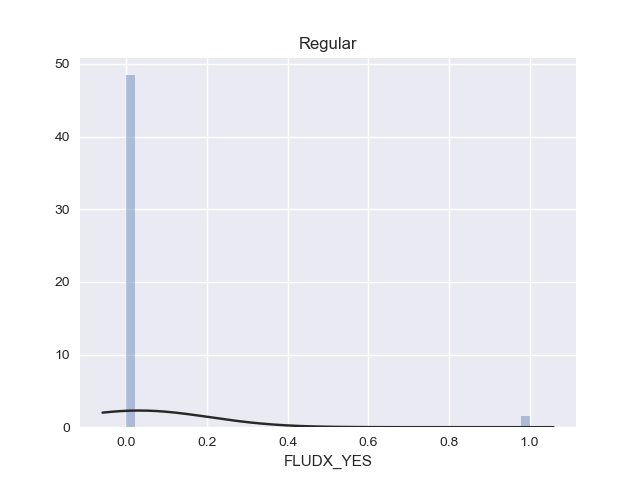

<IPython.core.display.Javascript object>


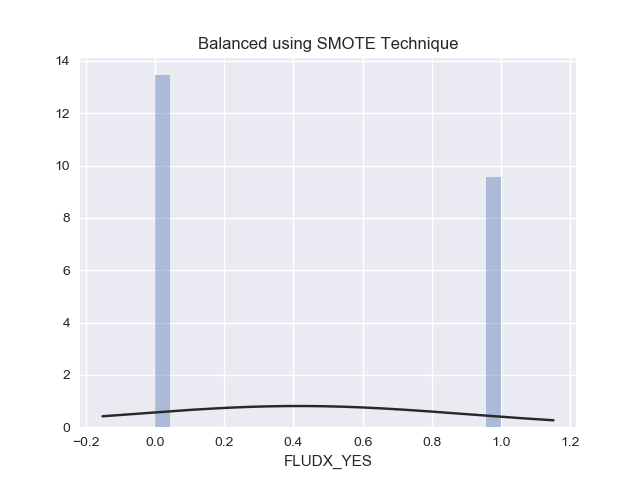

In [44]:
### Visualize DEnsity of Outcome Variable for Regular vs SMOTE Datasets
plt.figure(2); plt.title('Regular')
sns.distplot(df2['FLUDX_YES'], kde=False, fit=st.norm)

plt.figure(3); plt.title('Balanced using SMOTE Technique')
sns.distplot(df2smote['FLUDX_YES'], kde=False, fit=st.norm)

In [16]:
### Select Datasets depending on the Model Run

#### df2 regular
x_train = df2_x_train # Regular
y_train = df2_y_train # Regular
x_test = df2_x_test # Regular or SMOTE
y_test = df2_y_test # Regular or SMOTE

#### df2 smote
#x_train = df2_x_train_smote # SMOTE (Uncomment to Overwrite Regular x_train)
#y_train = df2_y_train_smote # SMOTE (Uncomment to Overwrite Regular x_test)


In [39]:
### Logistic Regression -- Regular / SMOTE

logit = LogisticRegression(random_state = 5026)

#### Class Weights
#logit = LogisticRegression(random_state = 5026, class_weight = 'balanced')     # Uncomment to Overwrite with Balanced Dataset

result= logit.fit(x_train,y_train)

logit_yhat = logit.predict(x_test)
logit_prob = logit.predict_proba(x_test)
logit_ci90 = (np.percentile(logit_prob[:,1],90)) 
logit_threshold = logit_ci90 # Sets threshold to 90th percentile of propensity scores
logit_yhat = np.where(logit_prob[:,1] >= logit_threshold,1,0)

### Evaluation Metrics
logit_accuracy =  round(metrics.accuracy_score(y_test, logit_yhat)*100,2)
print('\n Accuracy logit:\n', metrics.accuracy_score(y_test, logit_yhat) )
#print(' \n Intercept logit: ',logit.intercept_)
logit_coef = pd.DataFrame(logit.coef_[0], x_test.columns, columns=['logit_Coefficients'])
logit_confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, logit_yhat), columns=['predicted 0','predicted 1'], index =['actual 0','actual 1'] )
print('\n Confusion Matrix logit: \n',logit_confusion_matrix)
logit_auc = metrics.roc_auc_score(y_test, logit_yhat)
print('\n AUC: \n', logit_auc)
logit_f1 = f1_score(y_test, logit_yhat)
print('\n F_Score: \n', (logit_f1))

tn = logit_confusion_matrix.iloc[0,0]
fp = logit_confusion_matrix.iloc[0,1]
fn = logit_confusion_matrix.iloc[1,0]
tp = logit_confusion_matrix.iloc[1,1]
sensitivity = tp/(tp+fn)*100            
specificity = tn / (tn + fp) *100   



 Accuracy logit:
 0.8820139328689044

 Confusion Matrix logit: 
           predicted 0  predicted 1
actual 0        13816         1477
actual 1          386          111

 AUC: 
 0.5633799527696487

 F_Score: 
 0.10647482014388489


In [35]:
### Random Forest Model -- Regular / SMOTE

tree = RandomForestClassifier(random_state=5026)
#tree = RandomForestClassifier(class_weight = 'balanced', random_state=5026)  # Uncomment to Overwrite with Balanced Dataset

tree.fit(x_train, y_train)

tree_prob = tree.predict_proba(x_test)
tree_ci90 = (np.percentile(tree_prob[:,1],90))
tree_threshold = tree_ci90
tree_yhat = np.where(tree_prob[:,1] >= tree_threshold,1,0)


tree_confusion_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, tree_yhat), columns=['predicted 0','predicted 1'], index =['actual 0','actual 1'] )
print('\n Confusion Matrix Tree \n',tree_confusion_matrix)

tree_accuracy = metrics.accuracy_score(y_test, tree_yhat)
print( '\n Accuracy Tree: \n', tree_accuracy )

tree_prob = tree.predict_proba(x_test)
tree_prob = [p[1] for p in tree_prob]
tree_auc = roc_auc_score(y_test, tree_prob)
print( '\n AUC Tree: \n', tree_auc )

tree_f1 = f1_score(y_test, tree_yhat)
print('\n F_Score: \n', tree_f1)


 Confusion Matrix Tree 
           predicted 0  predicted 1
actual 0        13845         1448
actual 1          366          131

 Accuracy Tree: 
 0.8851171627612413

 AUC Tree: 
 0.7003113956083326

 F_Score: 
 0.12620423892100194


logistic AUC: 0.563
randomforest AUC: 0.711


<IPython.core.display.Javascript object>


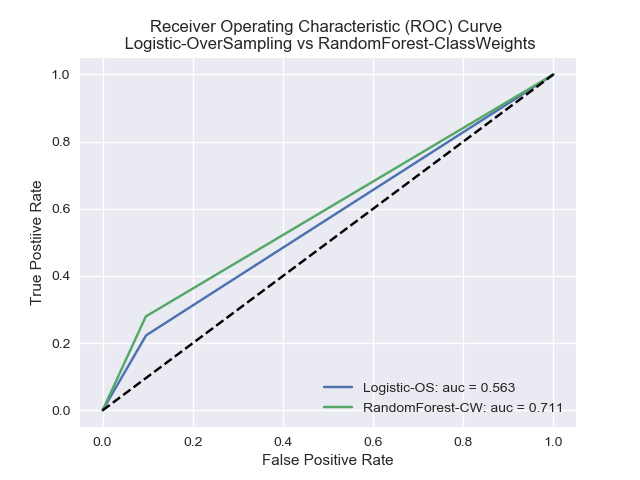

<function matplotlib.pyplot.show>

In [43]:
### Plotting ROC Curve

logit = LogisticRegression(random_state = 5026)
result= logit.fit(df2_x_train_smote,df2_y_train_smote)
logit_yhat = logit.predict(x_test)

logit_yhat = logit.predict(x_test)
logit_prob = logit.predict_proba(x_test)
logit_ci90 = (np.percentile(logit_prob[:,1],90))
logit_threshold = logit_ci90
logit_yhat = np.where(logit_prob[:,1] >= logit_threshold,1,0)

logit_fpr, logit_tpr, _ = metrics.roc_curve(y_test, logit_yhat)
logit_auc = round(metrics.roc_auc_score(y_test, logit_yhat),3)
print('logistic AUC:',logit_auc)

tree = RandomForestClassifier(class_weight = 'balanced', random_state=5026)
tree.fit(df2_x_train, df2_y_train)
tree_prob = tree.predict_proba(x_test)
tree_ci90 = (np.percentile(tree_prob[:,1],90))
tree_threshold = tree_ci90
tree_yhat = np.where(tree_prob[:,1] >= tree_threshold,1,0)

tree_fpr, tree_tpr, _ = metrics.roc_curve(y_test, tree_yhat)
tree_prob = [p[1] for p in tree_prob]
tree_auc= round(metrics.roc_auc_score(y_test, tree_prob),3)
print('randomforest AUC:',tree_auc)

plt.figure(4)
plt.plot(logit_fpr,logit_tpr,label="Logistic-OS: auc = "+str(logit_auc))
plt.plot(tree_fpr,tree_tpr,label="RandomForest-CW: auc = "+str(tree_auc))
plt.plot([0, 1], [0, 1],'k--')
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve \n Logistic-OverSampling vs RandomForest-ClassWeights')
plt.show